In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from catboost import CatBoostClassifier
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
import nltk

warnings.filterwarnings("ignore")

data = pd.read_csv("data/Twitter_Data.csv")

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

shape with NaN values: (162980, 2)
(162969, 2)
shape without NaN values: (162969, 2)


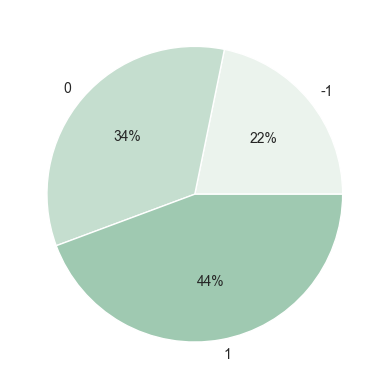

In [2]:
print(f"shape with NaN values: {data.shape}")
data = data.dropna()
print(data.shape)

print(f"shape without NaN values: {data.shape}")

data.head()

reviews = ["-1", "0", "1"]
number_of_reviews = [data['category'].value_counts()[x] for x in range(-1, 2)]

#define Seaborn color palette to use
colors = sns.light_palette('seagreen')[0:3]

#create pie chart
plt.pie(number_of_reviews, labels=reviews, colors=colors, autopct='%.0f%%')
plt.show()

In [3]:
def delete_punctuation_from_string(s: str):
    return re.sub(r'[^\w\s]', '', s)


data.loc[:, "clean_text"] = data["clean_text"].astype(str)
data.loc[:, "clean_text"] = data["clean_text"].apply(delete_punctuation_from_string)

In [4]:
train, test = train_test_split(data, random_state=239)

In [12]:
bow = CountVectorizer()

x_train = bow.fit_transform(train["clean_text"])
x_test = bow.transform(test["clean_text"])
y_train = train["category"]

import time

t = time.time()
model = CatBoostClassifier(task_type='GPU', learning_rate=0.3, iterations=1500)
model.fit(x_train, y_train, verbose=False)
print(time.time() - t)

# 116.26442384719849
# 0.9301598458959877

# 113.65503215789795 0.3 / 1000
# 0.9374714628447963

# 152.65503215789795 0.3 / 1500
# 0.9374714628447963

# 155.61173748970032
# 0.9399550699946421

y_test = test["category"]

y_pred = model.predict(x_test)

print(balanced_accuracy_score(y_pred, y_test))

155.61173748970032
0.9399550699946421


In [6]:
l = WordNetLemmatizer()


def lemmatize(x):
    x = map(lambda r: ' '.join([l.lemmatize(i.lower()) for i in r.split()]), x)
    x = np.array(list(x))
    return x


stop_words = stopwords.words('english')


def delete_stop_word(s):
    words = s.split()
    return " ".join([word for word in words if word.lower() not in stop_words])

In [7]:
# apply lemmatization
train["clean_text"] = lemmatize(train["clean_text"])
test["clean_text"] = lemmatize(test["clean_text"])

# delete stop words
train["clean_text"] = train["clean_text"].apply(delete_stop_word)
test["clean_text"] = test["clean_text"].apply(delete_stop_word)

In [8]:
bow = CountVectorizer()

x_train = bow.fit_transform(train["clean_text"])
x_test = bow.transform(test["clean_text"])
y_train = train["category"]
y_test = test["category"]

In [9]:
# Tuning CatBoostClassifier's hyperparameters

cb_model = CatBoostClassifier(verbose=False)

cb_param_grid = {
    'iterations': [500, 1000, 1500],
    'depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.15, 0.2, 0.3],
}

'''
param_grid = {
    'iterations': [100, 300, 500],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}
Best parameters: {'depth': 5, 'iterations': 500, 'learning_rate': 0.1}
Best score: 0.8655277927773142
Test set score: 0.8681736740053506
'''

cb_gs = GridSearchCV(estimator=cb_model, param_grid=cb_param_grid, cv=3, n_jobs=-1, verbose=3)

cb_gs.fit(x_train, y_train)

print("Best parameters:", cb_gs.best_params_)
print("Best score:", cb_gs.best_score_)

best_model = cb_gs.best_estimator_
test_score = best_model.score(x_test, y_test)
print("Test set score:", test_score)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'depth': 9, 'iterations': 1500, 'learning_rate': 0.3}
Best score: 0.886570778721385
Test set score: 0.8937240753012787


In [43]:


# clf = GridSearchCV(CatBoostClassifier(verbose=0), parameters)
clf = CatBoostClassifier(iterations=500, depth=5, learning_rate=0.1, verbose=False)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

In [44]:
balanced_accuracy_score(y_pred, y_test)  # parameters are bad.

0.8407455792950113

In [13]:
reviews = ["AMAZING I LOVE YOU ALL THERE", "I used your service once, but it was terrible"]

reviews = lemmatize(reviews)
reviews = bow.transform(reviews)

clf.predict(reviews)

NameError: name 'clf' is not defined